# Machine Learning with a Heart

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# for training our model
train_values = pd.read_csv('./data/train_values.csv', index_col='patient_id')
train_labels = pd.read_csv('./data/train_labels.csv', index_col='patient_id')

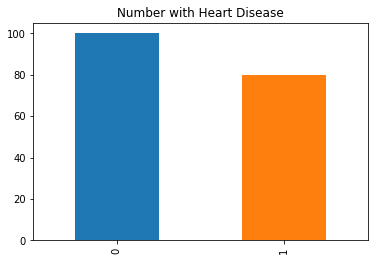

In [3]:
train_labels.heart_disease_present.value_counts().plot.bar(title='Number with Heart Disease')


In [4]:
df = (train_values.join(train_labels))

In [5]:
corr = df.corr()

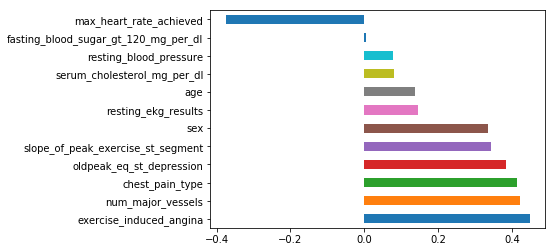

In [6]:
# correlation
(corr
     .heart_disease_present
     .drop('heart_disease_present') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [7]:
corr.sort_values(by = ["heart_disease_present"]).drop(["heart_disease_present"]).heart_disease_present


max_heart_rate_achieved                -0.375352
fasting_blood_sugar_gt_120_mg_per_dl    0.003379
resting_blood_pressure                  0.078506
serum_cholesterol_mg_per_dl             0.079775
age                                     0.138255
resting_ekg_results                     0.145933
sex                                     0.335421
slope_of_peak_exercise_st_segment       0.344224
oldpeak_eq_st_depression                0.382930
chest_pain_type                         0.412829
num_major_vessels                       0.421519
exercise_induced_angina                 0.448647
Name: heart_disease_present, dtype: float64

The following features chosen has the highest correlation. I will be using the selectted features in my machine learning algorithm (logistic regression)

In [89]:
#Features with high correlation - from kresta's analysis
selected_features = ['max_heart_rate_achieved', 
                     'oldpeak_eq_st_depression', 
                     'chest_pain_type', 
                     'num_major_vessels',
                       'exercise_induced_angina']
train_values_subset = train_values[selected_features]

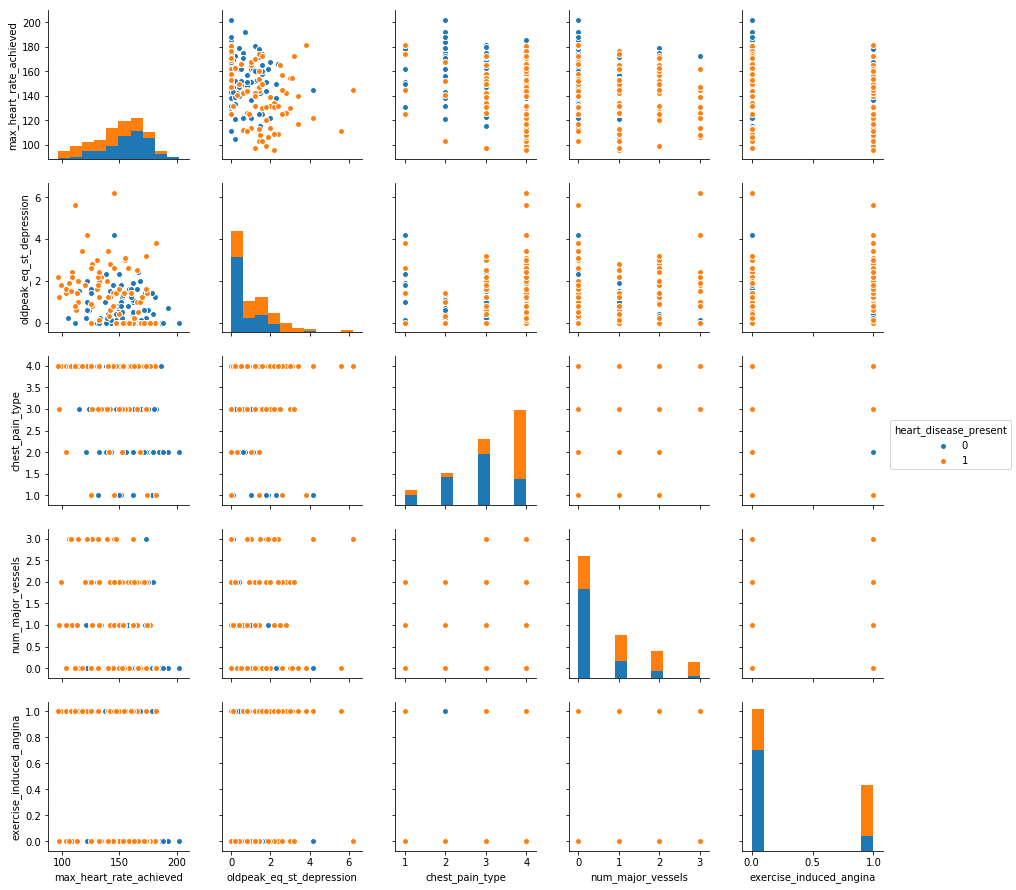

In [10]:
sns.pairplot(train_values.join(train_labels), 
             hue='heart_disease_present', 
             vars=selected_features)

In [11]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.linear_model import LogisticRegression

# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing parameters of the pipeline
from sklearn.model_selection import GridSearchCV

The DrivenData uses log loss as the evaluation of our predictions.
Log loss =−1n∑ni=1[yilog(y^i)+(1−yi)log(1−y^i)]
Logarithmic loss provides a steep penalty for predictions that are both confident and wrong. The goal is to minimize the log loss.The benchmark log loss is 0.5381

## Data Prep

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import train_test_split # splitting data
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.linear_model import LogisticRegression

# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing parameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [75]:
train_labels = pd.read_csv('data/train_labels.csv')
train_values = pd.read_csv('data/train_values.csv')
test_values = pd.read_csv('data/test_values.csv')
submission_format = pd.read_csv('data/submission_format.csv')

train_values.drop(['patient_id'], axis=1, inplace=True)
test_values.drop(['patient_id'], axis=1, inplace=True)
train_labels.drop(['patient_id'], axis=1, inplace=True)

train_values['thal'] = train_values['thal'].apply(lambda thal: 0 if thal == 'normal' else 1)
test_values['thal'] = test_values['thal'].apply(lambda thal: 0 if thal == 'normal' else 1)

all_data = train_values.join(train_labels)


In [16]:
scaler = MinMaxScaler()
test_df = scaler.fit_transform(test_values)
train_values = scaler.fit_transform(train_values)

train_features, test_features, train_outcome, test_outcome = train_test_split(
    train_values,
    train_labels['heart_disease_present'],
    test_size = 0.3,
    random_state = 11
)

### Random Forest

In [17]:
# Random Forest Regressor
rfr_reg = RandomForestRegressor()
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
selecter = SelectPercentile()
threshold = VarianceThreshold(.1)

# make pipeline
pipe = make_pipeline(threshold, scaler, selecter, rfr_reg)

# set parameters
params = {"randomforestregressor__n_estimators": range(1,20),
         'selectpercentile__percentile':range(10, 30, 3),
}

#perform grid search
grid_search = GridSearchCV(pipe, param_grid=params)
grid_search.fit(train_values, train_labels['heart_disease_present'])
grid_search.cv_results_['params'][grid_search.best_index_]

# grid search fit to training data
pred_train = grid_search.fit(train_features, train_outcome).predict(test_features)

In [18]:
# grid search fit to entire dataset
preds = grid_search.fit(train_values, train_labels['heart_disease_present']).predict(train_values)

In [19]:
# print results to csv
submission_format = submission_format.drop(['heart_disease_present'], axis = 1)
submission_format['heart_disease_present'] = pd.Series(preds)
submission_format.to_csv('random_forest_submission.csv',index=False)

### KNN Classifier

In [36]:
# Splitting data into train and test
train_features, test_features, train_outcome, test_outcome = train_test_split(
    train_values_subset,
    train_labels['heart_disease_present'],
    test_size = 0.3,
    random_state = 11
)

In [37]:
# K-Nearest Neighbors
knn_clf = KNeighborsClassifier(n_neighbors = 4)

In [38]:
# Peform Grid Search
params = {"n_neighbors": range(1, 40), "weights":["uniform", "distance"]}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv = folds, return_train_score=True)
grid_search.fit(train_features, train_outcome)
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [65]:
# KNN with best params from grid search
best_knn =  KNeighborsClassifier(n_neighbors = 4, weights='distance')
knn_preds = best_knn.fit(train_features, train_outcome).predict(test_features)
knn_preds

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0])

In [66]:
# fit model with all data
knn_clf_full = best_knn.fit(train_values_subset, train_labels['heart_disease_present'])

test_values_subset = test_values[selected_features]

knn_pred = knn_clf_full.predict(test_values_subset)

# print to submission format
submission_format['heart_disease_present'] = pd.Series(knn_pred, dtype=np.float64)
submission_format.to_csv('VanessaSubmission.csv',index=False)

### Logistic Regression

In [62]:
pipe = Pipeline(steps=[('scale', StandardScaler()), 
                       ('logistic', LogisticRegression())])
pipe

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [63]:
param_grid = {'logistic__C': [1], 
              'logistic__penalty': ['l2']}
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  cv=100)
gs.fit(train_values_subset, train_labels.heart_disease_present)
gs.best_params_

{'logistic__C': 1, 'logistic__penalty': 'l2'}

In [64]:
test_values = pd.read_csv('./data/test_values.csv', index_col='patient_id')
test_values_subset = test_values[selected_features]
predictions = gs.predict_proba(test_values_subset)[:, 1]
submission_format = pd.read_csv('./data/submission_format.csv', index_col='patient_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.to_csv('log_submission.csv')


### MLP Regressor

In [31]:
clf = MLPRegressor(solver='lbfgs')

pipe = make_pipeline(scaler, clf)

params = {'learning_rate': ["constant", "invscaling", "adaptive"]}

gs = GridSearchCV(clf, param_grid=params, n_jobs=-1, verbose=2, cv=10)

gs.fit(train_features, train_outcome)
gs.score(test_features, test_outcome)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.1s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.2s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.1s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.2s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.1s
[CV] learning_ra

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


0.4673770484992127

In [33]:
pred = gs.fit(train_features, train_outcome).predict(test_features).astype(np.float64)
pred2 = gs.fit(train_values, train_labels['heart_disease_present']).predict(train_values).astype(np.float64)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.1s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.1s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.1s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.3s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.2s
[CV] learning_ra

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.2s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.4s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.4s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.5s
[CV] learning_rate=constant ..........................................
[CV] ........................... learning_rate=constant, total=   0.3s
[CV] learning_rate=constant ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished


In [35]:
submission_format = pd.read_csv('data/submission_format.csv')
submission_format = submission_format.drop(['heart_disease_present'], axis = 1)
submission_format['heart_disease_present'] = pd.Series(predictions)
submission_format.to_csv('test_regressor.csv',index=False)

In [80]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go

x1=heart_disease_present.max_heart_rate_achieved 
x2=no_heart_disease.max_heart_rate_achieved

chart1 =go.Histogram(
    x=x1, 
    name='heart disease present')

chart2 =go.Histogram(x=x2, 
                     name='no heart disease')

data  = [chart1, chart2]
layout = go.Layout(
    title='Heart Disease Present by Max Heart Rate Achieved',
    xaxis=dict(
        title='Max Rate Heart Achieved'
    ),
    yaxis=dict(
        title='Count'
    ),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic histogram')

In [79]:
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
import numpy as np

x1=heart_disease.age
x2=no_heart_disease.age
trace1 = go.Histogram(
    x=x1,
    name='Heart Disease Present',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x2,
    name='No Heart Disease Present',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(
    title='Heart Disease Present by Age',
    xaxis=dict(
        title='Age'
    ),
    yaxis=dict(
        title='Count'
    ),
    barmode='overlay'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')


In [90]:
compare = pd.read_csv('./data/train_labels.csv')
compare['predictions'] = pred2
compare['age'] = train_values.age
compare['sex'] = train_values.sex

present = compare[compare.heart_disease_present == 1]
notPresent = compare[compare.heart_disease_present == 0]

heart_disease_present = go.Scatter(
    x = present.age,
    y = present.predictions,
    mode = 'markers',
    name = "1",
    marker = dict( size = 10,
            color = '#4da6ff',
            line = dict(width = 1)
    )
)

heart_disease_not_present = go.Scatter(
    x = notPresent.age,
    y = notPresent.predictions,
    mode = 'markers',
    name = "0",
    marker = dict( size = 10,
            color = '#ff8080',
            line = dict(width = 1)
)
)
data1 = [heart_disease_present,heart_disease_not_present]
    
layout1 = dict(title= 'Age v Predicted Probability of Heart Disease',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Age',
    ),
    yaxis=dict(
        title= 'Predicted Probability of Heart Disease',
    )
)

fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig)

In [91]:
# Plot for age v probability of heart disease
heart_disease_present2 = go.Scatter(
    x = present.sex,
    y = present.predictions,
    mode = 'markers', 
    name = "1",
    marker = dict(size= 14,
            color = '#4da6ff',
            line = dict(width = 1),
            opacity = 0.2
    )
)

heart_disease_not_present2 = go.Scatter(
    x = notPresent.sex,
    y = notPresent.predictions,
    mode = 'markers',
    name = '0',
    marker = dict(size= 14,
            color = '#ff8080',
            line = dict(width = 1),
            opacity = 0.2      
)
)
data2 = [heart_disease_present2,heart_disease_not_present2]
    
layout2 = dict(title= 'Sex v Predicted Probability of Heart Disease',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Sex',
    ),
    yaxis=dict(
        title= ' Predicted Probability of Heart Disease',
    )
)

fig = go.Figure(data=data2, layout=layout2)
py.iplot(fig, layout = layout2)